In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

# Load Data

In [ ]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders']], on='customer_db_id', how='left')
df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_created_month'] = df_ord.order_created_datetime.dt.month
df_ord['order_created_weekday'] = df_ord.order_created_datetime.dt.weekday
df_ord['order_created_year'] = df_ord.order_created_datetime.dt.year

In [4]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id')['quantity'].sum().reset_index()
df_ord = df_ord.merge(df_items, on='order_id', how='left')

# Filter data

In [5]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()

df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['frequency_comp'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform('mean')
df_comp['frequency_roll'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())

df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7
df_comp['weeks_since_last_comp'] = df_comp.days_since_last_comp // 7

df_comp['last_order_revenue'] = df_comp.groupby('customer_db_id')['revenue'].shift(1)
df_comp['last_revenue_diff'] = df_comp.revenue - df_comp.last_order_revenue

df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value

df_comp = df_comp.drop(['next_order_date', 'last_order_date', 'last_order_revenue'], axis=1)

# Customer Analysis

In [7]:
cust_sample = random.sample(df_comp.loc[df_comp.completed_orders == 15].customer_db_id.unique().tolist(), 9)
df_cust = df_comp.loc[df_comp.customer_db_id.isin(cust_sample)]

58826283457709d9648b470b
58a8512a447709fd588b4676
58bc4ae2467709830f8b45ea
58f337c6447709f2268b4591
58fe22934677098a258b4571
593d4378447709a9198b461e
59fc393b44770907268e121f
59fc396644770907268e26c2
5a51307f447709324e8b45f9


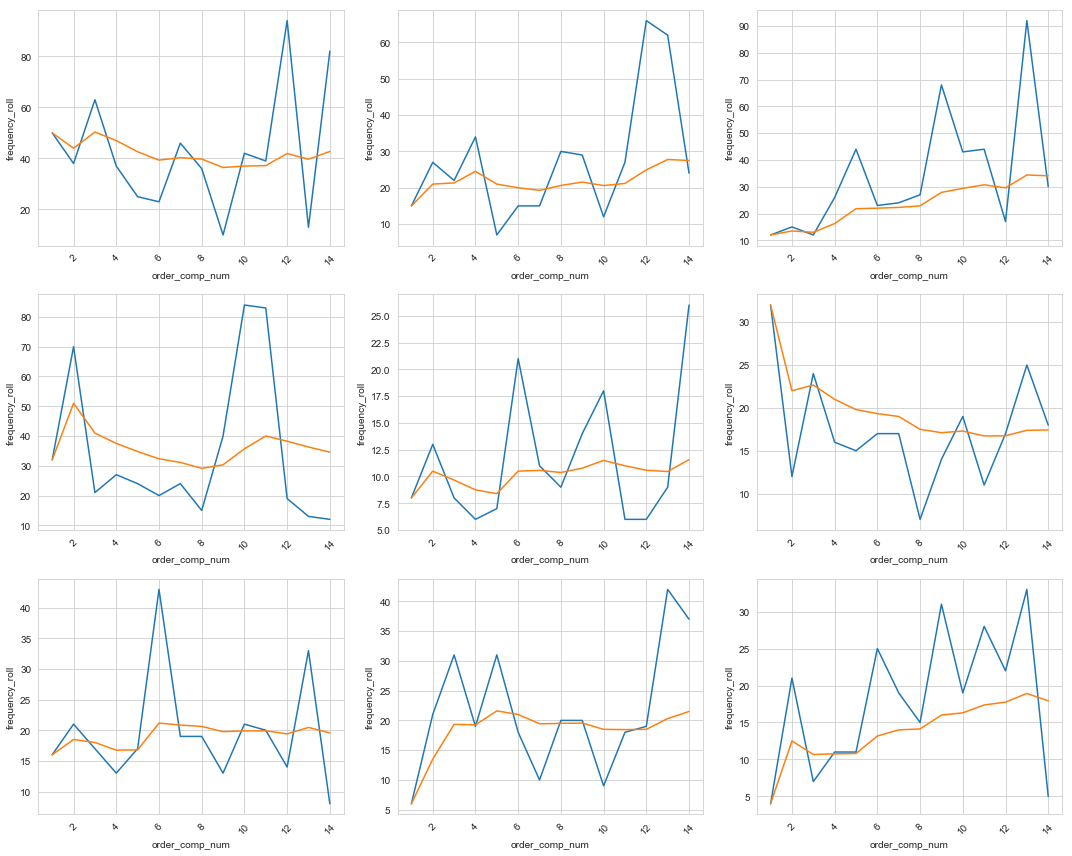

In [8]:
fig, axarr = plt.subplots(3, 3, figsize=(15,12))
i = -1
for idx, (cust_id, df) in enumerate(df_cust.groupby('customer_db_id')):
    print(cust_id)
    if idx % 3 == 0:
        i +=1 
    ax = axarr[i][idx % 3]
    sns.lineplot(data=df, x='order_comp_num', y='days_since_last_comp', ax=ax)
    sns.lineplot(data=df, x='order_comp_num', y='frequency_roll', ax=ax)
    
    ax.tick_params(axis='both', which='both', labelbottom=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_visible(True)

plt.tight_layout()

# Dataset

In [51]:
df_ord2 = df_ord.loc[(df_ord.completed_orders > 0) & (df_ord.order_state == "completed")]
df_ord2 = df_ord2.sort_values(['customer_db_id', 'order_created_datetime'])

df_ord2['order_comp_num'] = df_ord2.groupby(['customer_db_id']).cumcount()
df_ord2['order_created_datetime'] = pd.to_datetime(df_ord2.order_created_datetime)

df_ord2['next_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_ord2['last_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_ord2['days_until_next_comp'] = (df_ord2.next_order_date - df_ord2.order_created_datetime).dt.days
df_ord2['days_since_last_comp'] = (df_ord2.order_created_datetime - df_ord2.last_order_date).dt.days

df_ord2['weeks_until_next_comp'] = df_ord2.days_until_next_comp // 7
df_ord2['weeks_since_last_comp'] = df_ord2.days_since_last_comp // 7

df_ord2['last_order_revenue'] = df_ord2.groupby('customer_db_id')['revenue'].shift(1)
df_ord2['last_revenue_diff'] = df_ord2.revenue - df_ord2.last_order_revenue

df_ord2['revenue_brutto'] = df_ord2.revenue + df_ord2.voucher_value

df_ord2 = df_ord2.drop(['next_order_date', 'last_order_date', 'last_order_revenue'], axis=1)


# London - min. 3 orders

In [55]:
num_completed_orders = 4

In [56]:
cust_ids_excl = df_ord2.loc[(df_ord2.city != 'London') |
                            (df_ord2.days_until_next_comp > 150) | (df_ord2.days_until_next_comp == 0) |
                            (df_ord2.days_since_last_comp > 150) | (df_ord2.days_since_last_comp == 0) |
                            (df_ord2.revenue > 50) | (df_ord2.corporate) |
                            (df_ord2.completed_orders < num_completed_orders)].customer_db_id.unique().tolist()
print(len(cust_ids_excl), '/', df_ord2.customer_db_id.nunique())

29141 / 30175


In [57]:
df_city = df_ord2.loc[~(df_ord2.customer_db_id.isin(cust_ids_excl))]
df_city = df_city.loc[df_city.order_comp_num <= num_completed_orders]

In [58]:
print('Num orders:', df_city.order_id.nunique())
print('Num customers:', df_city.customer_db_id.nunique())

Num orders: 4894
Num customers: 1034


# Create Features

In [64]:
df_last_order = df_city.loc[df_city.order_comp_num == num_completed_orders]
df_last_order.frequency_roll

AttributeError: 'DataFrame' object has no attribute 'frequency_roll'

In [48]:
df_pivot = df_city.set_index(['customer_db_id', 'order_comp_num']).unstack().swaplevel(axis=1)
df_pivot.head()

order_comp_num,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
,order_id,order_id,order_id,order_id,order_id,order_db_id,order_db_id,order_db_id,order_db_id,order_db_id,...,cluster_8.0,cluster_8.0,cluster_8.0,cluster_8.0,cluster_8.0,cluster_9.0,cluster_9.0,cluster_9.0,cluster_9.0,cluster_9.0
customer_db_id,,,,,,,,,,,,,,,,,,,,,
5811cf91d2cde8195c3e8c49,GB-G-68226,GB-G-41803,GB-B-61702,GB-R-82470,GB-L-11342,58a43064457709bd788b46b1,58d966a3447709f7788b4664,59012a8f467709961a8b4607,59319732467709351f8b4650,598ee7ef457709f45d8b46ca,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586a563244770900208b464d,GB-K-24476,GB-W-60821,GB-Z-14135,GB-E-81010,GB-P-54948,586a563244770900208b4658,5887355d467709c1128b46e5,58a5a049467709a3218b46c5,58cd70c2447709e8618b4589,58e61b69447709b45c8b45a3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586b867d457709107e8b4661,GB-M-96804,GB-V-67931,GB-C-41848,GB-V-78598,NaN,586b8680457709db788b4722,587658be457709b72d8b45f3,58b46d8646770948628b462b,592e91c946770943368b4671,NaN,...,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
586c07be447709cd6c8b46b5,GB-Z-68831,GB-R-62960,GB-W-46068,GB-X-01412,GB-K-73422,586c07ca4577092f288b4651,5895d400457709e94d8b45c2,58a3533e447709d07e8b4594,58bbc0c64577098d798b45b3,58cd443944770946568b4673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586c3b0045770913318b45f1,GB-R-42882,GB-S-02976,GB-R-74332,GB-F-70854,NaN,586c3b0244770958778b4602,58bfc79c447709c2058b461b,5975e077467709bc7e8b46a7,59dcb4f4467709353d8b461d,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


# EDA

In [ ]:
df_city.revenue_brutto.describe()

In [ ]:
df_city.gender.value_counts()

In [ ]:
df_city.days_until_next_comp.hist(bins=50)

In [ ]:
plt.xticks(rotation=70)
sns.categorical.boxplot(data=df_city, x='cluster_name', y='weeks_until_next_comp')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_city.loc[df_city.order_created_year == 2017], x='order_created_month', y='weeks_until_next_comp')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_known.loc[df_known.order_created_year == 2018], x='order_created_month', y='days_until_next_comp')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_known, x='order_created_weekday', y='weeks_until_next_comp')

In [ ]:
sns.categorical.boxplot(data=df_known, x='gender', y='weeks_until_next_comp')

In [ ]:
sns.categorical.boxplot(data=df_known, x='service_class', y='weeks_until_next_comp')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=df_known, x='order_x', y='order_y', hue='weeks_until_next_comp', alpha=0.8, legend=False)

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_known, x='voucher_channel', y='days_until_next_comp')

In [ ]:
sns.scatterplot(data=df_known.loc[df_known.voucher_value > 0], x='voucher_value', y='weeks_until_next_comp', alpha=0.5, legend=False)

In [ ]:

sns.boxplot(data=df_known, x='quantity', y='days_until_next_comp')

In [ ]:
df_known.corr()['weeks_until_next_comp'].sort_values()

In [ ]:
df_known.revenue_brutto.hist(bins=50)

In [ ]:
df_known.shape

# Predictions

In [ ]:
df_known.set_index(['customer_db_id', 'order_num']).unstack().swaplevel(axis=1)

In [ ]:
feats = ['gender', 'revenue_brutto', 'weeks_since_last_comp',
        'order_created_month'] + df_known.columns[-10:].tolist()
feats

In [ ]:
# features
df_feats = df_known[['weeks_until_next_comp'] + feats]

df_feats['gender'] = df_feats.gender.map({'male': -1, 'female': 1}).fillna(0)

In [ ]:
sns.heatmap(df_feats.corr())

In [ ]:
X = df_feats.iloc[:, 1:].values
y = df_feats.iloc[:, 0].values
n_classes =  df_feats.iloc[:, 0].nunique()
n_classes

In [ ]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = y.reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42)

In [ ]:
sns.distplot(y_test, bins=20)

In [ ]:
log_reg = linear_model.LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print('train', log_reg.score(X_train, y_train), 'test', log_reg.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_train, log_reg.predict(X_train).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))
acc = metrics.accuracy_score(y_test, log_reg.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
sns.distplot(log_reg.predict(X_test), bins=20)

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, log_reg.predict(X_test).reshape(-1,1)))
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
lin_reg = linear_model.LinearRegression().fit(X_train, y_train)
print('train', lin_reg.score(X_train, y_train), 'test', lin_reg.score(X_test, y_test)) 

In [ ]:
sns.distplot(lin_reg.predict(X_test), bins=20)

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, lin_reg.predict(X_test).round()))
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
sup = svm.SVC(class_weight='balanced', verbose=True, gamma='auto').fit(X_train, y_train)
print('train', sup.score(X_train, y_train), 'test', sup.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_test, sup.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=40).fit(X_train, y_train) 
neigh.score(X_test, y_test)
print('train', neigh.score(X_train, y_train), 'test', neigh.score(X_test, y_test))
acc = metrics.f1_score(y_test, neigh.predict(X_test), average='weighted')
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
frst = RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced').fit(X_train, y_train)
print('train', frst.score(X_train, y_train), 'test', frst.score(X_test, y_test))
acc = metrics.accuracy_score(y_test, frst.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=1, max_iter=1000, 
                    learning_rate_init=0.001, verbose=True, batch_size=1, alpha=0.9).fit(X_train, y_train)
print('train', mlp.score(X_train, y_train), 'test', mlp.score(X_test, y_test))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)
acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, mlp.predict(X_test).reshape(-1,1)))

In [ ]:
bys = linear_model.BayesianRidge().fit(X_train, y_train)
print('train', bys.score(X_train, y_train), 'test', bys.score(X_test, y_test))

In [ ]:
bys.predict(X_test)

In [ ]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")